# Histogram of Oriented Gradients (HOG)

The histogram of oriented gradients (HOG) is a feature descriptor used in computer vision and image processing for the purpose of object detection. The technique counts occurrences of gradient orientation in localized portions of an image. This method is similar to that of edge orientation histograms, scale-invariant feature transform descriptors, and shape contexts, but differs in that it is computed on a dense grid of uniformly spaced cells and uses overlapping local contrast normalization for improved accuracy.

The essential thought behind the histogram of oriented gradients descriptor is that local object appearance and shape within an image can be described by the distribution of intensity gradients or edge directions. The image is divided into small connected regions called cells, and for the pixels within each cell, a histogram of gradient directions is compiled. The descriptor is the concatenation of these histograms. For improved accuracy, the local histograms can be contrast-normalized by calculating a measure of the intensity across a larger region of the image, called a block, and then using this value to normalize all cells within the block. This normalization results in better invariance to changes in illumination and shadowing.

The HOG descriptor has a few key advantages over other descriptors. Since it operates on local cells, it is invariant to geometric and photometric transformations, except for object orientation. Such changes would only appear in larger spatial regions. Moreover, as Dalal and Triggs discovered, coarse spatial sampling, fine orientation sampling, and strong local photometric normalization permits the individual body movement of pedestrians to be ignored so long as they maintain a roughly upright position. The HOG descriptor is thus particularly suited for human detection in images. **(Wikipedia)**

<hr>

### Loading and Displaying the Image

In [1]:
# Importing the libraries
import copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2 

%matplotlib inline

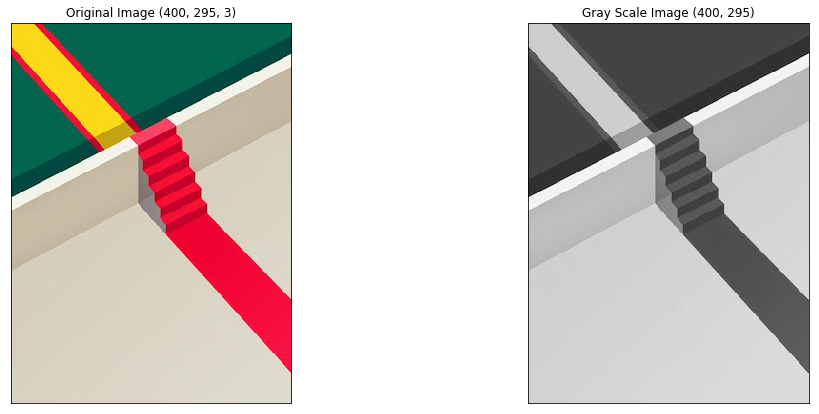

In [2]:
# Setting the default figure size
plt.rcParams['figure.figsize'] = [17.0, 7.0]

# Loading the image
image = cv2.imread("./images/graphic_img.jpg")

# Converting BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Converting RGB to Gray scale
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Visualizing the image
plt.subplot(121)
plt.title("Original Image " + str(image.shape))
plt.imshow(image)
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.title("Gray Scale Image " + str(gray_image.shape))
plt.imshow(gray_image, cmap = 'gray')
plt.xticks([])
plt.yticks([])

plt.show()

<hr>

### Creating HOG Descriptor (Feature Vector)

<br>
<figure>
  <img src = "./in_cell_images/HOG Diagram2.png" width = "100%" style = "border: thin silver solid; padding: 1px">
      <figcaption style = "text-align:left; font-style:italic">Fig. 1. - HOG Diagram. (Taken from Udacity)</figcaption>
</figure> 
<br>

In [3]:
# Parameters for HOG descriptor
cell_size = (6, 6)
num_cells_per_block = (2, 2)
h_stride = 1
v_stride = 1
num_bins = 9

# Setting parameters for HOG descriptor

# Block size
block_size = (num_cells_per_block[0] * cell_size[0],
              num_cells_per_block[1] * cell_size[1])

# Total number of cells in image
x_cell = gray_image.shape[1] // cell_size[0]
y_cell = gray_image.shape[0] // cell_size[1]

# Block stride
block_stride = (cell_size[0] * h_stride, 
                cell_size[1] * v_stride)

# Window size
win_size = (x_cell * cell_size[0],
            y_cell * cell_size[1])

# Printing the parameters
print("==========================================")
print("| HOG Descriptor Parameters:")
print("| ")
print("| ==> Window size: ", win_size)
print("| ==> Cell size: ", cell_size)
print("| ==> Block size: ", block_size)
print("| ==> Block stride of: ", block_stride)
print("| ==> Number of bins: ", num_bins)
print("==========================================\n")

# Setting the parameters of HOG descriptor
HOG = cv2.HOGDescriptor(win_size,                       # Size of detection window in pixels 
                        block_size,                     # Defines how many cells are in each block. 
                        block_stride,                   # Defines the distance between adjecent blocks
                        cell_size,                      # Determines the size fo your cell
                        num_bins)                       # Number of bins for the histograms.
                        #win_sigma = DEFAULT_WIN_SIGMA, # Default: Gaussian smoothing window parameter.
                        #threshold_L2hys = 0.2,         # Default: L2-Hys (Lowe-style clipped L2 norm) normalization method shrinkage. The L2-Hys method is used to normalize the blocks and it consists of an L2-norm followed by clipping and a renormalization.
                        #gamma_correction = True        # Default: Flag to specify whether the gamma correction preprocessing is required or not. 
                        #nlevels = DEFAULT_NLEVELS)     # Default: Maximum number of detection window increases.

# Compute HOG descriptor for gray scale image
HOG_descriptor = HOG.compute(gray_image) 

print("==========================================")
print("| ==> HOG Descriptor's shape: ", HOG_descriptor.shape)
print("==========================================\n")

| HOG Descriptor Parameters:
| 
| ==> Window size:  (294, 396)
| ==> Cell size:  (6, 6)
| ==> Block size:  (12, 12)
| ==> Block stride of:  (6, 6)
| ==> Number of bins:  9

| ==> HOG Descriptor's shape:  (112320, 1)



<hr>

### Number of elements in HOG descriptor

#### Number of elements in HOG descriptor
The HOG descriptor is a long vector containing the normalized histograms from cells and from blocks in detection window. The total size or elemets of HOG feature vector can be calculated by:

<span class="mathquill">
\begin{equation}
\mbox{Total elements} = (\mbox{Number of blocks})\mbox{ } \times \mbox{ } (\mbox{Number of cells in block})\mbox{ } \times \mbox{ } (\mbox{Number of bins})
\end{equation}
</span>


#### Number of blocks in width and height of the detection window

The total number of blocks in width or height can be calculated by:

<span class="mathquill">
\begin{equation}
\mbox{Total number of blocks}_i = \left(\frac{\mbox{(Total number of cells)}_i - \mbox{(Number of cells in block)}_i}{Stride_i}\right) + 1\mbox{  }; \mbox{  for  } i = x,y
\end{equation}
</span>


For example for getting the number of blocks in width of the detection window, we can calculate:


<span class="mathquill">
\begin{equation}
\mbox{Total number of blocks}_x = \left(\frac{\mbox{(Total number of cells)}_x - \mbox{(Number of cells in block)}_x}{Stride_x}\right) + 1\mbox{  }
\end{equation}
</span>


Or for getting the number of blocks in height of the detection window, we can calculate:


<span class="mathquill">
\begin{equation}
\mbox{Total number of blocks}_y = \left(\frac{\mbox{(Total number of cells)}_y - \mbox{(Number of cells in block)}_y}{Stride_y}\right) + 1\mbox{  }
\end{equation}
</span>

In [4]:
# Total number of blocks in width of the detection window
total_blocks_x = np.uint32(((x_cell - num_cells_per_block[0]) / h_stride) + 1)
print("==> Total number of blocks in width of the detection window: ", total_blocks_x)

# Total number of blocks in height of the detection window
total_blocks_y = np.uint32(((y_cell - num_cells_per_block[1]) / v_stride) + 1)
print("==> Total number of blocks in height of the detection window: ", total_blocks_y)

# Total number of elements in feature vector
total_elements = (total_blocks_x) * (total_blocks_y) * num_cells_per_block[0] * num_cells_per_block[1] * num_bins
print("==> Total elements: ", total_elements)

==> Total number of blocks in width of the detection window:  48
==> Total number of blocks in height of the detection window:  65
==> Total elements:  112320


<hr>

### Visualizing the HOG descriptor

In [5]:
# Setting the default figure size
plt.rcParams['figure.figsize'] = [10, 20]

In [6]:
# Reshaping the feature vector to: [block_y, block_x, num_cells_block_x, num_cells_per_block_y, num_bins]
hog_descriptor_reshaped = HOG_descriptor.reshape(total_blocks_x,
                                                 total_blocks_y,
                                                 num_cells_per_block[0],
                                                 num_cells_per_block[1],
                                                 num_bins)


# Transposing the blocks_x and blocks_y: the first index (blocks_y) referes to the row number and the second index to the column number.
hog_descriptor_reshaped = hog_descriptor_reshaped.transpose((1, 0, 2, 3, 4))

print("==> Shape of the HOG descriptor before reshaping: ", HOG_descriptor.shape)
print("==> Shape of the HOG descriptor after reshaping: ", hog_descriptor_reshaped.shape)

==> Shape of the HOG descriptor before reshaping:  (112320, 1)
==> Shape of the HOG descriptor after reshaping:  (65, 48, 2, 2, 9)


In [7]:
# Initializing "Average Gradient per Cell" with zeros
ave_grad = np.zeros((y_cell, x_cell, num_bins))


print("==> Shape of the average gradient: ", ave_grad.shape)

==> Shape of the average gradient:  (66, 49, 9)


In [8]:
# Initializing an array of zeros for counting the number of histograms per cell
hist_counter = np.zeros((y_cell, x_cell, 1))

print("==> Shape of the histogram counter: ", hist_counter.shape)

==> Shape of the histogram counter:  (66, 49, 1)


In [9]:
# Adding up all the histograms for each cell

# Iterating through horizontal cells
for i in range (num_cells_per_block[0]):
    
    # Iterating through vertival celss
    for j in range(num_cells_per_block[1]):
        
        # Average gradient per cell
        ave_grad[i:total_blocks_y + i,
                 j:total_blocks_x + j] += hog_descriptor_reshaped[:, :, i, j, :]
        
        # Histogram counter
        hist_counter[i:total_blocks_y + i,
                     j:total_blocks_x + j] += 1

In [10]:
# Average gradient for each cell
ave_grad /= hist_counter

In [11]:
# Total number of vectors in all cells
len_vecs = ave_grad.shape[0] * ave_grad.shape[1] * ave_grad.shape[2]

print("==> Total number of vecctors in all cells: ", len_vecs)

==> Total number of vecctors in all cells:  29106


In [12]:
# Equally spacing degrees between 0-180 degrees radians to the num_bins
deg = np.linspace(0, np.pi, num_bins, endpoint = False)

print("==> Total length of our degrees: ", len(deg), "\n")
print("==> Degrees (radians): ", ["{0:.2f}".format(i) for i in deg])

==> Total length of our degrees:  9 

==> Degrees (radians):  ['0.00', '0.35', '0.70', '1.05', '1.40', '1.75', '2.09', '2.44', '2.79']


<hr>

Each cell will have a histogram with num_bins. For each cell, plot each bin as a vector so as:

- **Height of the bin =** vector's magnitude

- **Bins on x axis =** vector's angle

For doing so, create rank 1 arrays for holding the **(x,y)-coordinate** of all the vectors in all the cells in the image. and also, create the rank 1 arrays for holding all the **(U,V)-components** of all the vectors in all the cells in the image.

In [13]:
# Creating arrays for holding components of vector
U = np.zeros((len_vecs))
V = np.zeros((len_vecs))

# Creating arrays for holding positions of vector
X = np.zeros((len_vecs))
Y = np.zeros((len_vecs))

In [14]:
# Set the counter to zero
counter = 0

# Calculating the positions and components

# Iterating thorogh x axis of average_gradients
for i in range(ave_grad.shape[0]):
    
    # Iterating through y axis of average_gradients
    for j in range(ave_grad.shape[1]):
        
        # Iterating through z axis of average_gradients
        for k in range(ave_grad.shape[2]):
            
            # Computing Components
            U[counter] = ave_grad[i,j,k] * np.cos(deg[k])
            V[counter] = ave_grad[i,j,k] * np.sin(deg[k])
        
            # Computing positions
            X[counter] = (cell_size[0] / 2) + (cell_size[0] * i)
            Y[counter] = (cell_size[1] / 2) + (cell_size[1] * j)
        
            # Incrementing the counter
            counter = counter + 1

In [15]:
# Equally spacing degrees between 0-180 degrees (not radians) to the num_bins
angle_axis = np.linspace(0, 180, num_bins, endpoint = False)

print("==> Total length of our degrees: ", len(angle_axis), "\n")
print("==> Degrees (before): ", ["{0:.2f}".format(i) for i in angle_axis], '\n')

# Adding (half of two degrees = 10) degrees to each
angle_axis += ((angle_axis[1] - angle_axis[0]) / 2)

print("==> Degrees (after): ", ["{0:.2f}".format(i) for i in angle_axis])

==> Total length of our degrees:  9 

==> Degrees (before):  ['0.00', '20.00', '40.00', '60.00', '80.00', '100.00', '120.00', '140.00', '160.00'] 

==> Degrees (after):  ['10.00', '30.00', '50.00', '70.00', '90.00', '110.00', '130.00', '150.00', '170.00']


Sometimes you have to run the below cell twice.

<IPython.core.display.Javascript object>


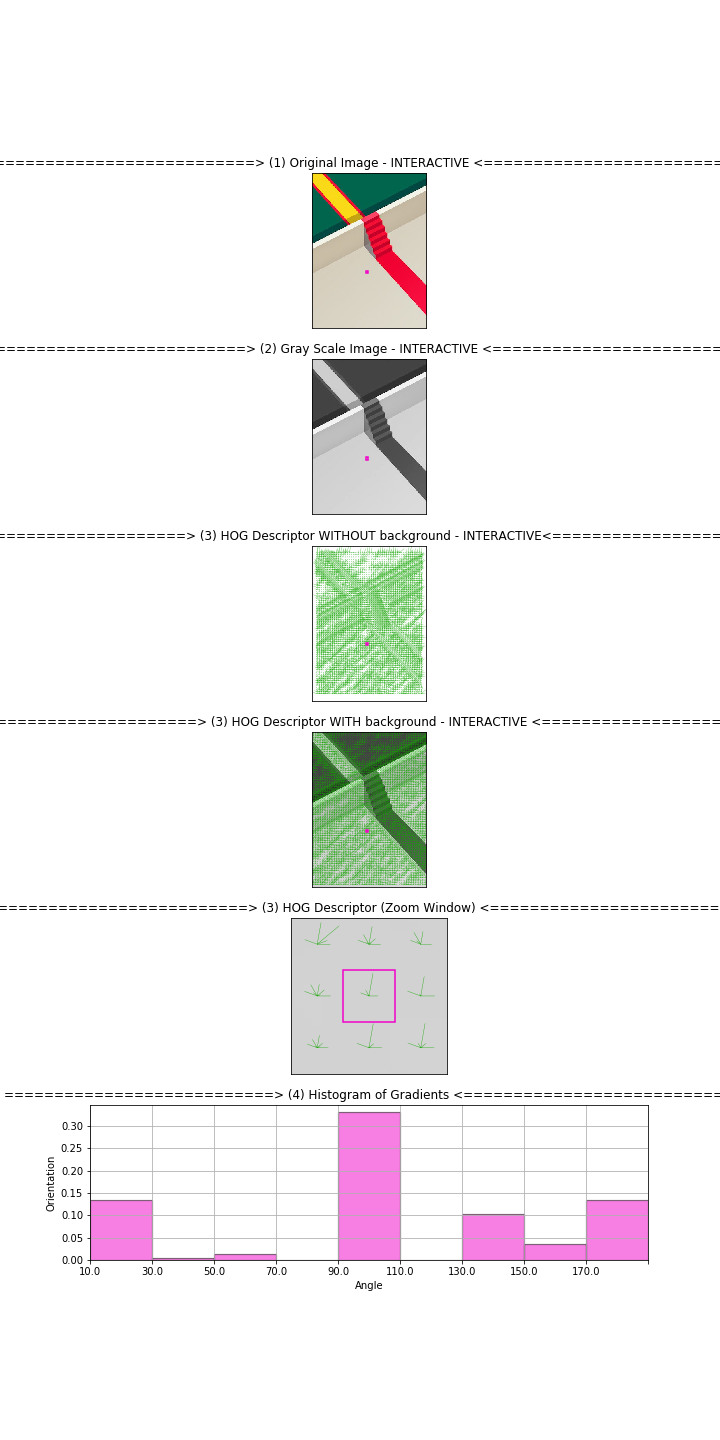

In [20]:
%matplotlib notebook

# Setting the default figure size
plt.rcParams['figure.figsize'] = [10, 20]

# Creating figures with 5 subplots
fig, (a, b, c1, c2, d, e) = plt.subplots(6, 1)

# Defining colors

greenish = '#16a704'

""" Visualizing BEFORE interactive mode """

# Visializing (a - Original image)
a.imshow(image)
a.set_title("===========================> (1) Original Image - INTERACTIVE <===========================")
a.set_aspect(aspect = 1)
a.xaxis.set_visible(False)
a.yaxis.set_visible(False)

# Visualizing (b - Gray scale image)
b.imshow(gray_image, cmap = 'gray')
b.set_title("===========================> (2) Gray Scale Image - INTERACTIVE <===========================")
b.set_aspect(aspect = 1)
b.xaxis.set_visible(False)
b.yaxis.set_visible(False)

# Visualizing (c1 - HOG descriptor or feature vector WITHOUT background))
c1.quiver(Y, X, U, V, color = greenish, headwidth = 0, headlength = 0, scale_units = 'inches', scale = 5)
c1.invert_yaxis() # Because it's upside down
c1.set_aspect(aspect = 1)
c1.set_facecolor('white')
c1.set_title("===========================> (3) HOG Descriptor WITHOUT background - INTERACTIVE <===========================")
c1.xaxis.set_visible(False)
c1.yaxis.set_visible(False)

# Visualizing (c2 - HOG descriptor or feature vector WITH background))
c2.quiver(Y, X, U, V, color = greenish, headwidth = 0, headlength = 0, scale_units = 'inches', scale = 5)
c2.invert_yaxis() # Because it's upside down
c2.set_aspect(aspect = 1)
c2.imshow(gray_image, cmap = 'gray')
c2.set_facecolor('white')
c2.set_title("===========================> (3) HOG Descriptor WITH background - INTERACTIVE <===========================")
c2.xaxis.set_visible(False)
c2.yaxis.set_visible(False)

# Set the title in d and e
d.set(title = '===========================> (3) HOG Descriptor (Zoom Window) <===========================', xlim = (0, 18), ylim = (0, 18), autoscale_on = False)
e.set(title = '===========================> (4) Histogram of Gradients <===========================')
e.set_xticklabels(angle_axis)
e.set_xlabel('Angle')
e.set_ylabel("Orientation")
"""
# Eliminiating the axis number in d and e
d.xaxis.set_visible(False)
d.yaxis.set_visible(False)
e.xaxis.set_visible(False)
e.yaxis.set_visible(False)
"""


""" Visualizing after interactive mode """
# Define function for interactive zoom
def onpress(event):
    
    #Unless the left mouse button is pressed do nothing
    if event.button != 1:
        return
    
    # Only accept clicks for subplots a and b
    if event.inaxes in [a, b, c1, c2]:
        
        # Get mouse click coordinates
        x, y = event.xdata, event.ydata
        
        # Select the cell closest to the mouse click coordinates
        cell_num_x = np.uint32(x / cell_size[0])
        cell_num_y = np.uint32(y / cell_size[1])
        
        # Set the edge coordinates of the rectangle patch
        edgex = x - (x % cell_size[0])
        edgey = y - (y % cell_size[1])
        
        # Create a rectangle patch that matches the the cell selected above        
        rect = patches.Rectangle((edgex, edgey),
                                  cell_size[0], cell_size[1],
                                  linewidth = 1.5,
                                  edgecolor = '#f000c8',
                                  facecolor='none')
        
        # A single patch can only be used in a single plot. Create copies of the patch to use in the other subplots
        rect2 = copy.copy(rect)
        rect3 = copy.copy(rect)
        rect4 = copy.copy(rect)
        rect5 = copy.copy(rect)
        
        
        # Updating (a - Original image)
        a.clear()
        a.set(title = '===========================> (1) Original Image - INTERACTIVE <===========================')
        a.imshow(image)
        a.set_aspect(aspect = 1)
        a.add_patch(rect)
        a.xaxis.set_visible(False)
        a.yaxis.set_visible(False)
        
        # Updating (b - Gray scale image)
        b.clear()
        b.set(title = '===========================> (2) Gray Scale Image - INTERACTIVE <===========================')
        b.imshow(gray_image, cmap = 'gray')
        b.set_aspect(aspect = 1)
        b.add_patch(rect2)
        b.xaxis.set_visible(False)
        b.yaxis.set_visible(False)
        
        # Updating (c1 - HOG descriptor or feature vector WITHOUT background))
        c1.clear()
        c1.set(title = '===========================> (3) HOG Descriptor WITHOUT background - INTERACTIVE<===========================')
        c1.quiver(Y, X, U, V, color = greenish, headwidth = 0, headlength = 0, scale_units = 'inches', scale = 5)
        c1.invert_yaxis()
        c1.set_aspect(aspect = 1)
        c1.set_facecolor('white')
        c1.add_patch(rect3)
        c1.xaxis.set_visible(False)
        c1.yaxis.set_visible(False)
        
        # Updating (c2 - HOG descriptor or feature vector WITHOUT background))
        c2.clear()
        c2.set(title = '===========================> (3) HOG Descriptor WITH background - INTERACTIVE <===========================')
        c2.quiver(Y, X, U, V, color = greenish, headwidth = 0, headlength = 0, scale_units = 'inches', scale = 5)
        c2.invert_yaxis()
        c2.set_aspect(aspect = 1)
        c2.set_facecolor('white')
        c2.imshow(gray_image, cmap = 'gray')
        c2.add_patch(rect4)
        c2.xaxis.set_visible(False)
        c2.yaxis.set_visible(False)
        c2.imshow(gray_image, cmap = 'gray')
        
        # Updating (d - Zoom window)
        d.clear()
        d.set(title = '===========================> (3) HOG Descriptor (Zoom Window) <===========================')
        d.quiver(Y, X, U, V, color = greenish, headwidth = 0, headlength = 0, scale_units = 'inches', scale = 1)
        d.set_xlim(edgex - cell_size[0], edgex + (2 * cell_size[0]))
        d.set_ylim(edgey - cell_size[1], edgey + (2 * cell_size[1]))
        d.invert_yaxis()
        d.set_aspect(aspect = 1)
        d.set_facecolor('white')
        d.add_patch(rect5)
        d.xaxis.set_visible(False)
        d.yaxis.set_visible(False)
        d.imshow(gray_image, cmap = 'gray')

        # Updating (e - Histogram of gradients)
        e.clear()
        e.set(title = '===========================> (4) Histogram of Gradients <===========================')
        e.grid()
        e.set_xlim(0, 180)
        e.set_xticklabels(angle_axis)
        e.set_xlabel('Angle')
        e.set_ylabel("Orientation")
        e.bar(angle_axis,
              ave_grad[cell_num_y, cell_num_x, :],
              180 // num_bins,
              align = 'center',
              alpha = 0.5,
              linewidth = 1.2,
              edgecolor = 'k',
              color = '#f000c8')

        fig.canvas.draw()

# Create a connection between the figure and the mouse click
fig.canvas.mpl_connect('button_press_event', onpress)
plt.show()